# Data exploration on the SoNaR corpus

In [5]:
import pandas as pd
import xml.etree.ElementTree as ET
from azure.storage.blob import BlobServiceClient
from io import StringIO
import os
from dotenv import load_dotenv
from collections import Counter
import csv
import numpy as np
import pandas as pd
import re
from openai import OpenAI, AsyncOpenAI
import tiktoken
import concurrent.futures
import asyncio
from enum import Enum
from pydantic import BaseModel
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import nltk
import string

# initialize the OpenAI client
openai_client = OpenAI(api_key=os.getenv("general_API"))
async_openai_client = AsyncOpenAI(api_key=os.getenv("general_API"))

# Load environment variables from the .env file
load_dotenv()

# Azure Blob Storage configuration
connection_string = os.getenv("SONAR_STORAGE_KEY")


In [151]:
container_name = "books"
output_file_wordcount_and_10gram_perfile = f"../out/{container_name}/wordcount_and_10gram_perfile_{container_name}.csv"
output_file_fulltext = f"../out/{container_name}/combined_{container_name}.txt"
output_csv_wordfrequencies = f"../out/{container_name}/word_frequencies_{container_name}.csv"
gendered_output_csv = f"../out/{container_name}/gendered_wordpairs_{container_name}.csv"
professions_output_csv = f"../out/{container_name}/professions_{container_name}.csv"

### Counting the number of words and 10-grams in a subset of the corpus

In [101]:
class BlobProcessor:
    def __init__(self, connection_string, container_name, output_file):
        self.connection_string = connection_string
        self.container_name = container_name
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        self.container_client = self.blob_service_client.get_container_client(container_name)
        self.data = []
        self.output_file = output_file
    
    def list_blobs(self):
        """List all blobs in the container."""
        return list(self.container_client.list_blobs())
    
    def process_xml_files(self):
        """Process XML files in the container and compute word counts and 10-grams."""
        blobs = self.list_blobs()
        xml_files = [blob.name for blob in blobs if blob.name.endswith('.xml')]
        print(f"XML files: {xml_files}")
        print(f"Processing {len(blobs)} files...")
        print(f"First 5 files: {[blob.name for blob in blobs][:5]}")

        total_files = len(blobs)
        for i, blob in enumerate(blobs, start=1):
            blob_name = blob.name
            print(f"Processing file {blob_name} ({i}/{total_files})")

            if blob_name.endswith('.xml'):
                try:
                    # Download blob content
                    blob_client = self.container_client.get_blob_client(blob_name)
                    blob_data = blob_client.download_blob().readall()
                    print(f"Blob data: {blob_data[:100]}")  # Preview first 100 bytes

                    # Parse XML content
                    xml_content = blob_data.decode('iso-8859-15')
                    tree = ET.ElementTree(ET.fromstring(xml_content))
                    root = tree.getroot()

                    # Count <w> elements
                    word_count = len(root.findall('.//dcoi:w', {'dcoi': 'http://lands.let.ru.nl/projects/d-coi/ns/1.0'}))
                except ET.ParseError as e:
                    print(f"Error parsing {blob_name}: {e}")
                    word_count = 0

                # Calculate the number of 10-grams
                ten_grams = max(0, word_count - 10 + 1)
                
                # Append results
                self.data.append({
                    'filename': blob_name,
                    'word_count': word_count,
                    'ten_grams': ten_grams
                })

                print(f"File {blob_name} processed: {i}/{total_files}")

    def get_dataframe(self):
        """Return the data as a Pandas DataFrame."""
        return pd.DataFrame(self.data)
    
    def save_dataframe(self):
        """Save the DataFrame to a file."""
        df = self.get_dataframe()
        df.to_csv(self.output_file, index=False)
        print(f"DataFrame saved to {self.output_file}")
    
    def get_total_ten_grams(self):
        """Calculate the total number of 10-grams."""
        if not self.data:
            return 0
        df = self.get_dataframe()
        return df['ten_grams'].sum()
    
    def summary(self):
        """Print a summary of the processing results."""
        df = self.get_dataframe()
        print(df)
        print(f"Total 10-grams: {self.get_total_ten_grams()}")

In [16]:
# Initialize BlobProcessor
processor = BlobProcessor(connection_string, container_name, output_file_wordcount_and_10gram_perfile)

# Process XML files
processor.process_xml_files()

# Print summary
processor.summary()

# Save DataFrame to a CSV file
processor.save_dataframe()

XML files: ['WR-P-E-K-0000000001.dcoi.xml', 'WR-P-E-K-0000000002.dcoi.xml', 'WR-P-E-K-0000000003.dcoi.xml', 'WR-P-E-K-0000000004.dcoi.xml', 'WR-P-E-K-0000000005.dcoi.xml', 'WR-P-E-K-0000000006.dcoi.xml', 'WR-P-E-K-0000000007.dcoi.xml', 'WR-P-E-K-0000000008.dcoi.xml', 'WR-P-E-K-0000000009.dcoi.xml', 'WR-P-E-K-0000000010.dcoi.xml', 'WR-P-E-K-0000000011.dcoi.xml', 'WR-P-E-K-0000000012.dcoi.xml', 'WR-P-E-K-0000000013.dcoi.xml', 'WR-P-E-K-0000000014.dcoi.xml', 'WR-P-E-K-0000000015.dcoi.xml', 'WR-P-E-K-0000000016.dcoi.xml', 'WR-P-E-K-0000000017.dcoi.xml', 'WR-P-E-K-0000000018.dcoi.xml', 'WR-P-E-K-0000000019.dcoi.xml', 'WR-P-E-K-0000000020.dcoi.xml', 'WR-P-E-K-0000000021.dcoi.xml', 'WR-P-E-K-0000000022.dcoi.xml', 'WR-P-E-K-0000000023.dcoi.xml', 'WR-P-E-K-0000000024.dcoi.xml', 'WR-P-E-K-0000000025.dcoi.xml', 'WR-P-E-K-0000000026.dcoi.xml', 'WR-P-E-K-0000000027.dcoi.xml', 'WR-P-E-K-0000000028.dcoi.xml', 'WR-P-E-K-0000000029.dcoi.xml', 'WR-P-E-K-0000000030.dcoi.xml', 'WR-P-E-K-0000000031.dcoi.xm

### Inspecting full text and topics

In [102]:
class BlobTextExtractor:
    def __init__(self, connection_string, container_name):
        self.connection_string = connection_string
        self.container_name = container_name
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        self.container_client = self.blob_service_client.get_container_client(container_name)

    def extract_text_from_blob(self, blob_name):
        """Extract text from <w> elements in a single blob."""
        try:
            # Download blob content
            blob_client = self.container_client.get_blob_client(blob_name)
            blob_data = blob_client.download_blob().readall()
            
            # Parse the XML content
            tree = ET.ElementTree(ET.fromstring(blob_data.decode('iso-8859-15')))
            root = tree.getroot()
            
            # Extract text from <w> elements
            word_elements = root.findall('.//dcoi:w', {'dcoi': 'http://lands.let.ru.nl/projects/d-coi/ns/1.0'})
            return ' '.join(w.text for w in word_elements if w.text)
        except Exception as e:
            print(f"Error processing blob {blob_name}: {e}")
            return ""

    def save_texts_to_single_file(self, output_file):
        """Extract text from all XML blobs in the container and save to a single file."""
        with open(output_file, 'w', encoding='utf-8') as outfile:
            # List all blobs in the container
            blobs = list(self.container_client.list_blobs())
            xml_files = [blob.name for blob in blobs if blob.name.endswith('.xml')]

            print(f"Found {len(xml_files)} XML files in container '{self.container_name}'.")

            for i, blob_name in enumerate(xml_files, start=1):
                print(f"Processing file {i}/{len(xml_files)}: {blob_name}")

                # Extract text from the blob
                text = self.extract_text_from_blob(blob_name)

                # Write the title (blob name without extension), text, and blank line to the output file
                outfile.write(f"{os.path.splitext(blob_name)[0]}\n")  # Write the title
                outfile.write(text)  # Write the extracted text
                outfile.write("\n\n")  # Add a blank line between entries
                
                print(f"Added text from {blob_name} to the combined file.")
        
        print(f"All texts saved to a single file at {output_file}.")

In [17]:
# Initialize the BlobTextExtractor
extractor = BlobTextExtractor(connection_string, container_name)

# Extract texts and save to a single output file
extractor.save_texts_to_single_file(output_file_fulltext)

Found 778 XML files in container 'blogs'.
Processing file 1/778: WR-P-E-K-0000000001.dcoi.xml
Added text from WR-P-E-K-0000000001.dcoi.xml to the combined file.
Processing file 2/778: WR-P-E-K-0000000002.dcoi.xml
Added text from WR-P-E-K-0000000002.dcoi.xml to the combined file.
Processing file 3/778: WR-P-E-K-0000000003.dcoi.xml
Added text from WR-P-E-K-0000000003.dcoi.xml to the combined file.
Processing file 4/778: WR-P-E-K-0000000004.dcoi.xml
Added text from WR-P-E-K-0000000004.dcoi.xml to the combined file.
Processing file 5/778: WR-P-E-K-0000000005.dcoi.xml
Added text from WR-P-E-K-0000000005.dcoi.xml to the combined file.
Processing file 6/778: WR-P-E-K-0000000006.dcoi.xml
Added text from WR-P-E-K-0000000006.dcoi.xml to the combined file.
Processing file 7/778: WR-P-E-K-0000000007.dcoi.xml
Added text from WR-P-E-K-0000000007.dcoi.xml to the combined file.
Processing file 8/778: WR-P-E-K-0000000008.dcoi.xml
Added text from WR-P-E-K-0000000008.dcoi.xml to the combined file.
Proces

### Counting per word

In [103]:
class BlobWordFrequencyAggregator:
    def __init__(self, connection_string, container_name):
        self.connection_string = connection_string
        self.container_name = container_name
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        self.container_client = self.blob_service_client.get_container_client(container_name)

    def extract_word_frequencies_from_blob(self, blob_name):
        """Extract word frequencies from a single blob."""
        try:
            # Download blob content
            blob_client = self.container_client.get_blob_client(blob_name)
            blob_data = blob_client.download_blob().readall()
            
            # Parse the XML content
            tree = ET.ElementTree(ET.fromstring(blob_data.decode('iso-8859-15')))
            root = tree.getroot()
            
            # Extract words from <w> elements
            word_elements = root.findall('.//dcoi:w', {'dcoi': 'http://lands.let.ru.nl/projects/d-coi/ns/1.0'})
            words = [w.text for w in word_elements if w.text]
            
            # Return word frequencies as a Counter
            return Counter(words)
        except Exception as e:
            print(f"Error processing blob {blob_name}: {e}")
            return Counter()

    def aggregate_word_frequencies(self):
        """Aggregate word frequencies from all XML blobs in the container."""
        total_frequencies = Counter()
        
        # List all XML blobs in the container
        blobs = list(self.container_client.list_blobs())
        xml_files = [blob.name for blob in blobs if blob.name.endswith('.xml')]

        print(f"Found {len(xml_files)} XML files in container '{self.container_name}'.")

        for i, blob_name in enumerate(xml_files, start=1):
            print(f"Processing file {i}/{len(xml_files)}: {blob_name}")
            
            # Extract word frequencies from the current blob
            word_frequencies = self.extract_word_frequencies_from_blob(blob_name)
            
            # Update the total frequencies with the current blob's frequencies
            total_frequencies.update(word_frequencies)
        
        return total_frequencies

    def save_aggregated_frequencies_to_csv(self, word_frequencies, output_file):
        """Save aggregated word frequencies to a CSV file."""
        # Sort words by frequency in descending order
        sorted_frequencies = sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)
        
        with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            # Write header
            writer.writerow(['Word', 'Frequency'])
            # Write sorted word and frequency data
            for word, freq in sorted_frequencies:
                writer.writerow([word, freq])
        
        print(f"Word frequencies saved to {output_file}.")

    def get_word_frequency_from_csv(self, word, csv_file):
        """Get the frequency of a single word from the CSV file."""
        try:
            # Load the CSV file into a DataFrame
            word_frequencies = pd.read_csv(csv_file, sep=',', on_bad_lines='skip')

            # Find the frequency for the given word
            word_df = word_frequencies[word_frequencies['Word'] == word]
            
            if not word_df.empty:
                frequency = word_df['Frequency'].iloc[0]
                print(f"The word '{word}' appears {frequency} time(s) in the CSV file.")
                return frequency
            else:
                print(f"The word '{word}' does not appear in the CSV file.")
                return 0
        except Exception as e:
            print(f"Error reading CSV file {csv_file}: {e}")
            return 0

In [18]:
# Initialize the BlobWordFrequencyAggregator
aggregator = BlobWordFrequencyAggregator(connection_string, container_name)

# Aggregate word frequencies
total_word_frequencies = aggregator.aggregate_word_frequencies()

# Save aggregated frequencies to a CSV file
aggregator.save_aggregated_frequencies_to_csv(total_word_frequencies, output_csv_wordfrequencies)


Found 778 XML files in container 'blogs'.
Processing file 1/778: WR-P-E-K-0000000001.dcoi.xml
Processing file 2/778: WR-P-E-K-0000000002.dcoi.xml
Processing file 3/778: WR-P-E-K-0000000003.dcoi.xml
Processing file 4/778: WR-P-E-K-0000000004.dcoi.xml
Processing file 5/778: WR-P-E-K-0000000005.dcoi.xml
Processing file 6/778: WR-P-E-K-0000000006.dcoi.xml
Processing file 7/778: WR-P-E-K-0000000007.dcoi.xml
Processing file 8/778: WR-P-E-K-0000000008.dcoi.xml
Processing file 9/778: WR-P-E-K-0000000009.dcoi.xml
Processing file 10/778: WR-P-E-K-0000000010.dcoi.xml
Processing file 11/778: WR-P-E-K-0000000011.dcoi.xml
Processing file 12/778: WR-P-E-K-0000000012.dcoi.xml
Processing file 13/778: WR-P-E-K-0000000013.dcoi.xml
Processing file 14/778: WR-P-E-K-0000000014.dcoi.xml
Processing file 15/778: WR-P-E-K-0000000015.dcoi.xml
Processing file 16/778: WR-P-E-K-0000000016.dcoi.xml
Processing file 17/778: WR-P-E-K-0000000017.dcoi.xml
Processing file 18/778: WR-P-E-K-0000000018.dcoi.xml
Processing fi

In [26]:
word_to_check = "zus"
aggregator.get_word_frequency_from_csv(word_to_check, output_csv_wordfrequencies)

The word 'zus' appears 3 time(s) in the CSV file.


3

### File locator word a specific word

In [153]:
class BlobWordSearcher:
    def __init__(self, connection_string, container_name):
        self.connection_string = connection_string
        self.container_name = container_name
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        self.container_client = self.blob_service_client.get_container_client(container_name)

    def find_blobs_with_word(self, target_word):
        """Find blobs in the container that contain the target word."""
        matching_blobs = []
        
        # List all XML blobs in the container
        blobs = list(self.container_client.list_blobs())
        xml_files = [blob.name for blob in blobs if blob.name.endswith('.xml')]

        print(f"Searching for the word '{target_word}' in {len(xml_files)} XML files.")

        for i, blob_name in enumerate(xml_files, start=1):
            print(f"Processing file {i}/{len(xml_files)}: {blob_name}")

            try:
                # Download blob content
                blob_client = self.container_client.get_blob_client(blob_name)
                blob_data = blob_client.download_blob().readall()

                # Parse the XML content
                tree = ET.ElementTree(ET.fromstring(blob_data.decode('iso-8859-15')))
                root_element = tree.getroot()

                # Search for the target word in all <w> elements
                word_elements = root_element.findall('.//dcoi:w', {'dcoi': 'http://lands.let.ru.nl/projects/d-coi/ns/1.0'})
                for word_element in word_elements:
                    if word_element.text and target_word in word_element.text:
                        matching_blobs.append(blob_name)
                        print(f"Word '{target_word}' found in {blob_name}")
                        break  # Stop searching this file if the word is found

            except ET.ParseError:
                print(f"Error parsing {blob_name}. Skipping.")

        return matching_blobs

In [154]:
search_word = "moeders"

# Initialize the BlobWordSearcher
searcher = BlobWordSearcher(connection_string, container_name)

# Search for blobs containing the word
blobs_with_word = searcher.find_blobs_with_word(search_word)

# Display the results
if blobs_with_word:
    print(f"The word '{search_word}' was found in the following blobs:")
    for blob in blobs_with_word:
        print(blob)
else:
    print(f"No blobs contain the word '{search_word}'.")

Searching for the word 'moeders' in 508 XML files.
Processing file 1/508: WR-P-P-B-0000000001.dcoi.xml
Processing file 2/508: WR-P-P-B-0000000002.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000002.dcoi.xml
Processing file 3/508: WR-P-P-B-0000000003.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000003.dcoi.xml
Processing file 4/508: WR-P-P-B-0000000004.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000004.dcoi.xml
Processing file 5/508: WR-P-P-B-0000000005.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000005.dcoi.xml
Processing file 6/508: WR-P-P-B-0000000006.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000006.dcoi.xml
Processing file 7/508: WR-P-P-B-0000000007.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000007.dcoi.xml
Processing file 8/508: WR-P-P-B-0000000008.dcoi.xml
Processing file 9/508: WR-P-P-B-0000000011.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000011.dcoi.xml
Processing file 10/508: WR-P-P-B-0000000012.dcoi.xml
Word 'moeders' found in WR-P-P-B-0000000012.dcoi.xml
Proc

### Generating genedered wordpairs and professions csv files

In [104]:
class BlobWordAnalyzer:
    def __init__(self, connection_string, container_name):
        self.connection_string = connection_string
        self.container_name = container_name
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        self.container_client = self.blob_service_client.get_container_client(container_name)

    def load_csv(self, file_path):
        """Load a CSV file into a Pandas DataFrame."""
        return pd.read_csv(file_path, sep=',', on_bad_lines='skip')

    def analyze_gendered_words(self, word_frequencies, gendered_wordpairs_list, output_csv):
        """Analyze gendered words and save the results to a CSV."""
        gendered_wordpairs = word_frequencies[word_frequencies['Word'].isin(gendered_wordpairs_list)].reset_index(drop=True)
        gendered_wordpairs['Word'] = gendered_wordpairs["Word"].str.lower()
        gendered_wordpairs = gendered_wordpairs.groupby(["Word"]).agg({"Frequency": "sum"}).reset_index()

        word_mapping = {
            "baron": ["baron"],
            "barones": ["barones"],
            "broer": ["broer", "broers"],
            "bruid": ["bruid", "bruiden"],
            "bruidegom": ["bruidegom", "bruidegoms"],
            "dame": ["dame", "dames"],
            "dochter": ["dochter", "dochters"],
            "gentleman": ["gentleman"],
            "gozer": ["gozer", "gozers"],
            "grootmoeder": ["grootmoeder", "grootmoeders"],
            "grootvader": ["grootvader", "grootvaders"],
            "heer": ["heer", "heren"],
            "hertog": ["hertog", "hertogen"],
            "hertogin": ["hertogin"],
            "hij": ["hij"],
            "hijzelf": ["hijzelf"],
            "jongen": ["jongen", "jongens"],
            "jongetje": ["jongetje", "jongetjes"],
            "kerel": ["kerel", "kerels"],
            "kleindochter": ["kleindochter", "kleindochters"],
            "kleinzoon": ["kleinzoon", "kleinzonen"],
            "koning": ["koning", "koningen"],
            "koningin": ["koningin", "koninginnen"],
            "lady": ["lady"],
            "lord": ["lord"],
            "mama": ["mama", "mama's", "mamma", "mamma's"],
            "man": ["man", "mannen"],
            "meid": ["meid", "meiden"],
            "meisje": ["meisje", "meisjes"],
            "meneer": ["meneer"],
            "mijnheer": ["mijnheer"],
            "mevrouw": ["mevrouw"],
            "miss": ["miss"],
            "mister": ["mister"],
            "moeder": ["moeder", "moeders"],
            "monnik": ["monnik", "monniken"],
            "mr": ["mr", "mr.", "mrs", "mrs."],
            "ms": ["ms", "ms."],
            "neef": ["neef", "neven"],
            "nicht": ["nicht", "nichten"],
            "non": ["non", "nonnen"],
            "oma": ["oma", "oma's"],
            "oom": ["oom", "ooms"],
            "opa": ["opa", "opa's"],
            "papa": ["papa", "papa's", "pappa", "pappa's"],
            "peetmoeder": ["peetmoeder"],
            "peetvader": ["peetvader"],
            "prins": ["prins", "prinsen"],
            "prinses": ["prinses", "prinsessen"],
            "schoondochter": ["schoondochter", "schoondochters"],
            "schoonmoeder": ["schoonmoeder", "schoonmoeders"],
            "schoonvader": ["schoonvader", "schoonvaders"],
            "schoonzoon": ["schoonzoon", "schoonzonen"],
            "stiefdochter": ["stiefdochter"],
            "stiefmoeder": ["stiefmoeder", "stiefmoeders"],
            "stiefvader": ["stiefvader", "stiefvaders"],
            "stiefzoon": ["stiefzoon", "stiefzonen"],
            "tante": ["tante", "tantes"],
            "vader": ["vader", "vaders"],
            "vrouw": ["vrouw", "vrouwen"],
            "mannelijk": ["mannelijk", "mannelijke"],
            "vrouwelijk": ["vrouwelijk", "vrouwelijke"],
            "wijf": ["wijf", "wijven"],
            "zij": ["zij"],
            "zijzelf": ["zijzelf"],
            "zoon": ["zoon", "zonen"],
            "zus": ["zus", "zussen"],
        }

        reverse_mapping = {plural: singular for singular, plurals in word_mapping.items() for plural in plurals}
        gendered_wordpairs["BaseWord"] = gendered_wordpairs["Word"].map(reverse_mapping)

        gendered_wordpairs.to_csv(output_csv, index=False)

        gendered_wordpairs_base = gendered_wordpairs.groupby(["BaseWord"]).agg({"Frequency": "sum"}).reset_index()
        gendered_wordpairs_base = gendered_wordpairs_base.sort_values(by='Frequency', ascending=False)

        return gendered_wordpairs, gendered_wordpairs_base

    def analyze_professions(self, word_frequencies, professions_list, output_csv):
        """Analyze professions and save the results to a CSV."""
        professions = word_frequencies[word_frequencies['Word'].isin(professions_list)].reset_index(drop=True)
        professions['Word'] = professions["Word"].str.lower()
        professions = professions.groupby(["Word"]).agg({"Frequency": "sum"}).reset_index()
        professions = professions.sort_values(by='Frequency', ascending=False)

        professions.to_csv(output_csv, index=False)
        return professions


In [35]:
# Initialize the word analyzer
analyzer = BlobWordAnalyzer(connection_string, container_name)

# Analyze gendered words
word_frequencies = analyzer.load_csv(output_csv_wordfrequencies)
gendered_wordpairs_list = [
    'man', 'vrouw',
    'Man', 'Vrouw',
    'mannen', 'vrouwen',
    'Mannen', 'Vrouwen',
    'jongen', 'meisje',
    'Jongen', 'Meisje',
    'jongens', 'meisjes',
    'Jongens', 'Meisjes',
    'jongetje', 'meisje',
    'Jongetje', 'Meisje',
    'jongetjes', 'meisjes',
    'Jongetjes', 'Meisjes',
    'kerel', 'meid',
    'Kerel', 'Meid',
    'kerels', 'meiden',
    'Kerels', 'Meiden',
    'gozer', 'meid',
    'Gozer', 'Meid',
    'gozers', 'meiden',
    'Gozers', 'Meiden',
    'gozer', 'wijf',
    'Gozer', 'Wijf',
    'gozers', 'wijven',
    'Gozers', 'Wijven',
    'gentleman', 'lady',
    'Gentleman', 'Lady',
    'lord', 'lady',
    'Lord', 'Lady',
    'heer', 'dame',
    'Heer', 'Dame',
    'heren', 'dames',
    'Heren', 'Dames',
    'meneer', 'mevrouw',
    'Meneer', 'Mevrouw',
    'mijnheer', 'mevrouw',
    'Mijnheer', 'Mevrouw',
    'mister', 'miss',
    'Mister', 'Miss',
    'Mr.', 'Ms.',
    'Mr', 'Ms',
    'Mr.', 'Mrs.',
    'Mr', 'Mrs',
    'mannelijk', 'vrouwelijk',
    'Mannelijk', 'Vrouwelijk',
    'mannelijke', 'vrouwelijke',
    'Mannelijke', 'Vrouwelijke',
    'koning', 'koningin',
    'Koning', 'Koningin',
    'koningen', 'koninginnen',
    'Koningen', 'Koninginnen',
    'prins', 'prinses',
    'Prins', 'Prinses',
    'prinsen', 'prinsessen',
    'Prinsen', 'Prinsessen',
    'hertog', 'hertogin',
    'Hertog', 'Hertogin',
    'hertogen', 'hertoginnen',
    'monnik', 'non',
    'Monnik', 'Non',
    'monniken', 'nonnen',
    'Monniken', 'Nonnen',
    'baron', 'barones',
    'Baron', 'Barones',
    'hij', 'zij',
    'Hij', 'Zij',
    'hijzelf', 'zijzelf',
    'Hijzelf', 'Zijzelf',
    'vader', 'moeder',
    'Vader', 'Moeder',
    'vaders', 'moeders',
    'Vaders', 'Moeders',
    'papa', 'mama',
    'Papa', 'Mama',
    'papa\'s', 'mama\'s',
    'Papa\'s', 'Mama\'s',
    'pappa', 'mamma',
    'Pappa', 'Mamma',
    'pappa\'s', 'mamma\'s',
    'Pappa\'s', 'Mamma\'s',
    'broer', 'zus',
    'Broer', 'Zus',
    'broers', 'zussen',
    'Broers', 'Zussen',
    'neef', 'nicht',
    'Neef', 'Nicht',
    'neven', 'nichten',
    'oom', 'tante',
    'Oom', 'Tante',
    'ooms', 'tantes',
    'grootvader', 'grootmoeder',
    'Grootvader', 'Grootmoeder',
    'grootvaders', 'grootmoeders',
    'Grootvaders', 'Grootmoeders',
    'opa', 'oma',
    'Opa', 'Oma',
    'opa\'s', 'oma\'s',
    'Opa\'s', 'Oma\'s',
    'zoon', 'dochter',
    'Zoon', 'Dochter',
    'zonen', 'dochters',
    'Zonen', 'Dochters',
    'kleinzoon', 'kleindochter',
    'Kleinzoon', 'Kleindochter',
    'kleinzonen', 'kleindochters',
    'schoonzoon', 'schoondochter',
    'Schoonzoon', 'Schoondochter',
    'schoonzonen', 'schoondochters',
    'stiefvader', 'stiefmoeder',
    'Stiefvader', 'Stiefmoeder',
    'stiefvaders', 'stiefmoeders',
    'Stiefvaders', 'Stiefmoeders',
    'stiefzoon', 'stiefdochter',
    'Stiefzoon', 'Stiefdochter',
    'stiefzonen', 'stiefdochters',
    'schoonvader', 'schoonmoeder',
    'schoonvaders', 'schoonmoeders',
    'bruidegom', 'bruid',
    'Bruidegom', 'Bruid',
    'bruidegoms', 'bruiden',
    'peetvader', 'peetmoeder',
    'Peetvader', 'Peetmoeder',
]
gendered_wordpairs, gendered_wordpairs_base = analyzer.analyze_gendered_words(word_frequencies, gendered_wordpairs_list, gendered_output_csv)

# Analyze professions
professions_list = [
    #"Pedagoog", "Pedagogen", "pedagoog", "pedagogen",
    #"Docent", "Docenten", "docent", "docenten",
    #"leraar", "leraren", "Leraar", "Leraren", 
    #"leerkracht", "leerkrachten", "Leerkracht", "Leerkrachten",
    #"onderwijzer", "onderwijzers", "Onderwijzer", "Onderwijzers",
    #"auteur", "auteurs", "Auteur", "Auteurs",
    #"Kunstenaar", "Kunstenaars", "kunstenaar", "kunstenaars",
    #"journalist", "journalisten", "Journalist", "Journalisten",
    #"fotograaf", "fotografen", "Fotograaf", "Fotografen",
    #"adviseur", "adviseurs", "Adviseur", "Adviseurs",
    #"vertegenwoordiger", "vertegenwoordigers", "Vertegenwoordiger", "Vertegenwoordigers",
    #"verkoper", "Verkoper",
    #"winkelier", "Winkelier",
    #"teamleider", "Teamleider",
    #"hoogleraar", "hoogleraren", "Hoogleraar", "Hoogleraren",
    #"apotheker", "apothekers", "Apotheker", "Apothekers",
    #"assistent", "assistenten", "Assistent", "Assistenten",
    #"conciërge", "conciërges", "Conciërge", "Conciërges",
    
    "technicus", #"Technicus",
    "accountant", "Accountant",
    "supervisor", #"Supervisor",
    "ingenieur", "Ingenieur",
    "arbeider", "Arbeider",
    #"klerk", "Klerk",
    "adviseur", "Adviseur",
    "inspecteur", "Inspecteur",
    "monteur", #"Monteur",
    'manager', 'Manager',
    "administrateur", "Administrateur", 
    "portier", "Portier",
    "psycholoog", "Psycholoog", 
    "arts", "Arts",
    "timmerman", "Timmerman",
    "verpleegkundige", "Verpleegkundige",
    "onderzoeker", "Onderzoeker",
    "barkeeper", #"Barkeeper",
    "specialist", "Specialist",
    "Deskundige", "deskundige",
    "expert", "Expert",
    "elektricien", #"Elektricien",
    "ambtenaar", #"Ambtenaar",
    "officier", "Officier",
    "beambte", #"Beambte",
    "patholoog", #"Patholoog",
    "jurist", "Jurist",
    "rechtsgeleerde", #"Rechtsgeleerde",
    "roostermaker", #"Roostermaker",
    "huisarts", "Huisarts",
    "loodgieter", #"Loodgieter",
    "dierenarts", "Dierenarts",
    "fysiotherapeut", "Fysiotherapeut",
    "scheikundige", "Scheikundige", 
    "machinist", "Machinist",
    "architect", "Architect",
    "bakker", "Bakker",
    "programmeur", #"Programmeur",
    "wetenschapper", #"Wetenschapper",
    "coördinator", "Coördinator",
    "kassier", #"Kassier",
    "schilder", "Schilder",
    "makelaar", "Makelaar",
    "chef", "Chef",
    "dokter", "Dokter",
    ]
professions = analyzer.analyze_professions(word_frequencies, professions_list, professions_output_csv)

### Summarizing the entire corpus

In [105]:
class CorpusSummaryAnalyzer:
    @staticmethod
    def analyze_corpus_summary(word_frequencies_file, gendered_wordpairs_file, professions_file, wordcount_and_10gram_file):
        """Generate a summary of the corpus analysis."""
        # Load CSV files
        word_frequencies = pd.read_csv(word_frequencies_file, sep=',', on_bad_lines='skip')
        gendered_wordpairs_base = pd.read_csv(gendered_wordpairs_file, sep=',', on_bad_lines='skip')
        professions = pd.read_csv(professions_file, sep=',', on_bad_lines='skip')
        wordcount_and_10gram = pd.read_csv(wordcount_and_10gram_file, sep=',', on_bad_lines='skip')

        total_words = word_frequencies['Frequency'].sum()
        total_ten_grams = wordcount_and_10gram['ten_grams'].sum()
        num_files = len(wordcount_and_10gram)

        total_frequency_gendered = gendered_wordpairs_base['Frequency'].sum()
        total_frequency_professions = professions['Frequency'].sum()

        summary = {
            "Total Words in Corpus": total_words,
            "Unique Words in Corpus": len(word_frequencies),
            "Gendered Words": len(gendered_wordpairs_base),
            "Frequency of Gendered Words": total_frequency_gendered,
            "Professions": len(professions),
            "Frequency of Professions": total_frequency_professions,
            "Number of Book Files": num_files,
            "Total 10-Grams": total_ten_grams,
        }

        return summary

In [37]:
# Summarize the corpus
summary = CorpusSummaryAnalyzer.analyze_corpus_summary(
    output_csv_wordfrequencies,
    gendered_output_csv,
    professions_output_csv,
    output_file_wordcount_and_10gram_perfile
)

for key, value in summary.items():
    print(f"{key}: {value}")

Total Words in Corpus: 8626248
Unique Words in Corpus: 264525
Gendered Words: 113
Frequency of Gendered Words: 45172
Professions: 41
Frequency of Professions: 2426
Number of Book Files: 18699
Total 10-Grams: 8457957


### Running everything at once

In [114]:
container_name = "subtitles"
output_file_wordcount_and_10gram_perfile = f"../out/{container_name}/wordcount_and_10gram_perfile_{container_name}.csv"
output_file_fulltext = f"../out/{container_name}/combined_{container_name}.txt"
output_csv_wordfrequencies = f"../out/{container_name}/word_frequencies_{container_name}.csv"
gendered_output_csv = f"../out/{container_name}/gendered_wordpairs_{container_name}.csv"
professions_output_csv = f"../out/{container_name}/professions_{container_name}.csv"

In [112]:
# ============== STEP 1 =================
# Initialize BlobProcessor
processor = BlobProcessor(connection_string, container_name, output_file_wordcount_and_10gram_perfile)

# Process XML files
processor.process_xml_files()

# Print summary
processor.summary()

# Save DataFrame to a CSV file
processor.save_dataframe()

# ============== STEP 2 =================
# Initialize the BlobTextExtractor
extractor = BlobTextExtractor(connection_string, container_name)

# Extract texts and save to a single output file
extractor.save_texts_to_single_file(output_file_fulltext)

# ============== STEP 3 =================
# Initialize the BlobWordFrequencyAggregator
aggregator = BlobWordFrequencyAggregator(connection_string, container_name)

# Aggregate word frequencies
total_word_frequencies = aggregator.aggregate_word_frequencies()

# Save aggregated frequencies to a CSV file
aggregator.save_aggregated_frequencies_to_csv(total_word_frequencies, output_csv_wordfrequencies)

# ============== STEP 4 =================
# Initialize the word analyzer
analyzer = BlobWordAnalyzer(connection_string, container_name)

# Analyze gendered words
word_frequencies = analyzer.load_csv(output_csv_wordfrequencies)
gendered_wordpairs_list = [
    'man', 'vrouw',
    'Man', 'Vrouw',
    'mannen', 'vrouwen',
    'Mannen', 'Vrouwen',
    'jongen', 'meisje',
    'Jongen', 'Meisje',
    'jongens', 'meisjes',
    'Jongens', 'Meisjes',
    'jongetje', 'meisje',
    'Jongetje', 'Meisje',
    'jongetjes', 'meisjes',
    'Jongetjes', 'Meisjes',
    'kerel', 'meid',
    'Kerel', 'Meid',
    'kerels', 'meiden',
    'Kerels', 'Meiden',
    'gozer', 'meid',
    'Gozer', 'Meid',
    'gozers', 'meiden',
    'Gozers', 'Meiden',
    'gozer', 'wijf',
    'Gozer', 'Wijf',
    'gozers', 'wijven',
    'Gozers', 'Wijven',
    'gentleman', 'lady',
    'Gentleman', 'Lady',
    'lord', 'lady',
    'Lord', 'Lady',
    'heer', 'dame',
    'Heer', 'Dame',
    'heren', 'dames',
    'Heren', 'Dames',
    'meneer', 'mevrouw',
    'Meneer', 'Mevrouw',
    'mijnheer', 'mevrouw',
    'Mijnheer', 'Mevrouw',
    'mister', 'miss',
    'Mister', 'Miss',
    'Mr.', 'Ms.',
    'Mr', 'Ms',
    'Mr.', 'Mrs.',
    'Mr', 'Mrs',
    'mannelijk', 'vrouwelijk',
    'Mannelijk', 'Vrouwelijk',
    'mannelijke', 'vrouwelijke',
    'Mannelijke', 'Vrouwelijke',
    'koning', 'koningin',
    'Koning', 'Koningin',
    'koningen', 'koninginnen',
    'Koningen', 'Koninginnen',
    'prins', 'prinses',
    'Prins', 'Prinses',
    'prinsen', 'prinsessen',
    'Prinsen', 'Prinsessen',
    'hertog', 'hertogin',
    'Hertog', 'Hertogin',
    'hertogen', 'hertoginnen',
    'monnik', 'non',
    'Monnik', 'Non',
    'monniken', 'nonnen',
    'Monniken', 'Nonnen',
    'baron', 'barones',
    'Baron', 'Barones',
    'hij', 'zij',
    'Hij', 'Zij',
    'hijzelf', 'zijzelf',
    'Hijzelf', 'Zijzelf',
    'vader', 'moeder',
    'Vader', 'Moeder',
    'vaders', 'moeders',
    'Vaders', 'Moeders',
    'papa', 'mama',
    'Papa', 'Mama',
    'papa\'s', 'mama\'s',
    'Papa\'s', 'Mama\'s',
    'pappa', 'mamma',
    'Pappa', 'Mamma',
    'pappa\'s', 'mamma\'s',
    'Pappa\'s', 'Mamma\'s',
    'broer', 'zus',
    'Broer', 'Zus',
    'broers', 'zussen',
    'Broers', 'Zussen',
    'neef', 'nicht',
    'Neef', 'Nicht',
    'neven', 'nichten',
    'oom', 'tante',
    'Oom', 'Tante',
    'ooms', 'tantes',
    'grootvader', 'grootmoeder',
    'Grootvader', 'Grootmoeder',
    'grootvaders', 'grootmoeders',
    'Grootvaders', 'Grootmoeders',
    'opa', 'oma',
    'Opa', 'Oma',
    'opa\'s', 'oma\'s',
    'Opa\'s', 'Oma\'s',
    'zoon', 'dochter',
    'Zoon', 'Dochter',
    'zonen', 'dochters',
    'Zonen', 'Dochters',
    'kleinzoon', 'kleindochter',
    'Kleinzoon', 'Kleindochter',
    'kleinzonen', 'kleindochters',
    'schoonzoon', 'schoondochter',
    'Schoonzoon', 'Schoondochter',
    'schoonzonen', 'schoondochters',
    'stiefvader', 'stiefmoeder',
    'Stiefvader', 'Stiefmoeder',
    'stiefvaders', 'stiefmoeders',
    'Stiefvaders', 'Stiefmoeders',
    'stiefzoon', 'stiefdochter',
    'Stiefzoon', 'Stiefdochter',
    'stiefzonen', 'stiefdochters',
    'schoonvader', 'schoonmoeder',
    'schoonvaders', 'schoonmoeders',
    'bruidegom', 'bruid',
    'Bruidegom', 'Bruid',
    'bruidegoms', 'bruiden',
    'peetvader', 'peetmoeder',
    'Peetvader', 'Peetmoeder',
]
gendered_wordpairs, gendered_wordpairs_base = analyzer.analyze_gendered_words(word_frequencies, gendered_wordpairs_list, gendered_output_csv)

# Analyze professions
professions_list = [
    "Pedagoog", "Pedagogen", "pedagoog", "pedagogen",
    "Docent", "Docenten", "docent", "docenten",
    "leraar", "leraren", "Leraar", "Leraren", 
    "leerkracht", "leerkrachten", "Leerkracht", "Leerkrachten",
    "onderwijzer", "onderwijzers", "Onderwijzer", "Onderwijzers",
    "auteur", "auteurs", "Auteur", "Auteurs",
    "Kunstenaar", "Kunstenaars", "kunstenaar", "kunstenaars",
    "journalist", "journalisten", "Journalist", "Journalisten",
    "fotograaf", "fotografen", "Fotograaf", "Fotografen",
    "adviseur", "adviseurs", "Adviseur", "Adviseurs",
    "vertegenwoordiger", "vertegenwoordigers", "Vertegenwoordiger", "Vertegenwoordigers",
    "verkoper", "Verkoper",
    "winkelier", "Winkelier",
    "teamleider", "Teamleider",
    "hoogleraar", "hoogleraren", "Hoogleraar", "Hoogleraren",
    "apotheker", "apothekers", "Apotheker", "Apothekers",
    "assistent", "assistenten", "Assistent", "Assistenten",
    "conciërge", "conciërges", "Conciërge", "Conciërges",
    
    "technicus", "Technicus",
    "accountant", "Accountant",
    "supervisor", "Supervisor",
    "ingenieur", "Ingenieur",
    "arbeider", "Arbeider",
    "klerk", "Klerk",
    "adviseur", "Adviseur",
    "inspecteur", "Inspecteur",
    "monteur", "Monteur",
    'manager', 'Manager',
    "administrateur", "Administrateur", 
    "portier", "Portier",
    "psycholoog", "Psycholoog", 
    "arts", "Arts",
    "timmerman", "Timmerman",
    "verpleegkundige", "Verpleegkundige",
    "onderzoeker", "Onderzoeker",
    "barkeeper", "Barkeeper",
    "specialist", "Specialist",
    "Deskundige", "deskundige",
    "expert", "Expert",
    "elektricien", "Elektricien",
    "ambtenaar", "Ambtenaar",
    "officier", "Officier",
    "beambte", "Beambte",
    "patholoog", "Patholoog",
    "jurist", "Jurist",
    "rechtsgeleerde", "Rechtsgeleerde",
    "roostermaker", "Roostermaker",
    "huisarts", "Huisarts",
    "loodgieter", "Loodgieter",
    "dierenarts", "Dierenarts",
    "fysiotherapeut", "Fysiotherapeut",
    "scheikundige", "Scheikundige", 
    "machinist", "Machinist",
    "architect", "Architect",
    "bakker", "Bakker",
    "programmeur", "Programmeur",
    "wetenschapper", "Wetenschapper",
    "coördinator", "Coördinator",
    "kassier", "Kassier",
    "schilder", "Schilder",
    "makelaar", "Makelaar",
    "chef", "Chef",
    "dokter", "Dokter",
    ]
professions = analyzer.analyze_professions(word_frequencies, professions_list, professions_output_csv)

# ============== STEP 5 =================
# Summarize the corpus
summary = CorpusSummaryAnalyzer.analyze_corpus_summary(
    output_csv_wordfrequencies,
    gendered_output_csv,
    professions_output_csv,
    output_file_wordcount_and_10gram_perfile
)

for key, value in summary.items():
    print(f"{key}: {value}")

XML files: ['WR-P-P-B-0000000071.dcoi.xml', 'WR-P-P-B-0000000072.dcoi.xml', 'WR-P-P-B-0000000073.dcoi.xml', 'WR-P-P-B-0000000074.dcoi.xml', 'WR-P-P-B-0000000075.dcoi.xml', 'WR-P-P-B-0000000076.dcoi.xml', 'WR-P-P-B-0000000077.dcoi.xml', 'WR-P-P-B-0000000078.dcoi.xml', 'WR-P-P-B-0000000079.dcoi.xml', 'WR-P-P-B-0000000080.dcoi.xml', 'WR-P-P-B-0000000081.dcoi.xml', 'WR-P-P-B-0000000082.dcoi.xml', 'WR-P-P-B-0000000083.dcoi.xml', 'WR-P-P-B-0000000084.dcoi.xml', 'WR-P-P-B-0000000085.dcoi.xml', 'WR-P-P-B-0000000086.dcoi.xml', 'WR-P-P-B-0000000087.dcoi.xml', 'WR-P-P-B-0000000088.dcoi.xml', 'WR-P-P-B-0000000089.dcoi.xml', 'WR-P-P-B-0000000090.dcoi.xml', 'WR-P-P-B-0000000091.dcoi.xml', 'WR-P-P-B-0000000092.dcoi.xml', 'WR-P-P-B-0000000093.dcoi.xml', 'WR-P-P-B-0000000094.dcoi.xml', 'WR-P-P-B-0000000095.dcoi.xml', 'WR-P-P-B-0000000096.dcoi.xml', 'WR-P-P-B-0000000097.dcoi.xml', 'WR-P-P-B-0000000098.dcoi.xml', 'WR-P-P-B-0000000099.dcoi.xml', 'WR-P-P-B-0000000245.dcoi.xml', 'WR-P-P-B-0000000246.dcoi.xm

### Topic analysis using GPT-4

In [134]:
class DataFrameMaker:
    def __init__(self, file_path):
        self.file_path = file_path
        self.valid_sections = {}
        self.df = None

    def read_file(self):
        print("Reading file...")
        with open(self.file_path, "r", encoding="utf-8") as file:
            content = file.read()
        return content

    def split_sections(self, content):
        print("Splitting content into sections...")
        sections = re.split(r"\n\s*\n+", content)  # Split on blank lines

        for sec in sections:
            lines = sec.strip().split("\n")

            # Identify the title line (ending in .dcoi)
            title_line = next((line for line in lines if re.match(r"^\S+\.dcoi$", line)), None)

            # Remove the title from the lines and clean the rest
            cleaned_lines = [line for line in lines if line != title_line]

            # Store in dictionary if a valid title exists
            if title_line and cleaned_lines:
                self.valid_sections[title_line] = " ".join(cleaned_lines)

        print(f"Extracted {len(self.valid_sections)} valid sections.")

    def make_dataframe(self):
        print("Making dataframe...")
        self.df = pd.DataFrame(self.valid_sections.items(), columns=["Title", "Text"])
        print("Processing complete!")

    def run(self):
        content = self.read_file()
        self.split_sections(content)
        self.make_dataframe()

In [135]:
dfmaker = DataFrameMaker(output_file_fulltext)
dfmaker.run()

df = dfmaker.df
df.head()

Reading file...
Splitting content into sections...
Extracted 8368 valid sections.
Making dataframe...
Processing complete!


Title  \
0  0/WR-P-E-G-0000000001.dcoi   
1  0/WR-P-E-G-0000000002.dcoi   
2  0/WR-P-E-G-0000000006.dcoi   
3  0/WR-P-E-G-0000000008.dcoi   
4  0/WR-P-E-G-0000000009.dcoi   

                                                                                                                                                                                                                                                        Text  
0  Subtitles for afritnegen 9.8.99 In deze uitzending : Luk Demarey , schakel tussen boer en slager Alfons Morret , weekend-ridder Verlekkerd op ' Vragen staat vrij ' Alain Rinckhout van de improvisatie-liga Frans Van Hool en zijn kalebassen Dat is ...  
1  Subtitles for Boerenkrijg , afl. 1 Au ! Aaah ! Stommerik ! Het is de verkeerde ! Deze zal nooit meer pijn doen . - Ik kom hier nooit meer . Hela , vergeet je niks ? Geld hoeft niet . In natura is ook goed . Het overschot mag je houden . Kom , ik ...  
2                                                                                                                                                            Subtitles for program1 ghndghjdjdghj ghjgjgj sdfghfhfh khkhkyyiy ykykykykyk hkhkhkhjkjhk kkllkl  
3                                                                                                                                                                  Subtitles for testuitzending Dit zijn enkele testtitels . En nog een paar . Dat was het .  
4                                                                                                                                       Subtitles for testuitzending Dit zijn enkele testtitels . En nog een paar . Dat was het . Hier is een nieuwe titel .

In [115]:
class EmbeddingProcessor:
    def __init__(self, file_path, openai_client, max_tokens=8100, num_workers=4):
        self.file_path = file_path
        self.openai_client = openai_client
        self.max_tokens = max_tokens
        self.num_workers = num_workers  # Number of parallel workers
        self.tokenizer = tiktoken.get_encoding("cl100k_base")
        self.valid_sections = []
        self.df = None
        self.matrix = None

    def read_file(self):
        print("Reading file...")
        with open(self.file_path, "r", encoding="utf-8") as file:
            content = file.read()
        return content

    def split_sections(self, content):
        print("Splitting content into sections...")
        sections = re.split(r"\n\s*\n+", content)
        
        for sec in sections:
            lines = sec.strip().split("\n")
            cleaned_lines = [line for line in lines if not re.match(r"^\S+\.dcoi$", line)]
            if cleaned_lines:
                self.valid_sections.append(" ".join(cleaned_lines))
        
        print(f"Extracted {len(self.valid_sections)} valid sections.")

    def split_into_chunks(self, text):
        tokens = self.tokenizer.encode(text)
        chunks = [self.tokenizer.decode(tokens[i:i+self.max_tokens]) for i in range(0, len(tokens), self.max_tokens)]
        print(f"Split text into {len(chunks)} chunks.")
        return chunks

    def get_embedding(self, text):
        """Fetches embedding for a given text."""
        try:
            response = self.openai_client.embeddings.create(
                model="text-embedding-3-small",
                input=text
            )
            return np.array(response.data[0].embedding)
        except Exception as e:
            print(f"Error generating embedding: {e}")
            return np.zeros(1536)

    def process_section(self, text, index, total):
        """Processes a single section, splitting it into chunks and averaging embeddings."""
        print(f"Processing section {index+1}/{total} in parallel...")
        chunks = self.split_into_chunks(text)
        embeddings = np.array([self.get_embedding(chunk) for chunk in chunks])
        averaged_embedding = np.mean(embeddings, axis=0)
        print(f"Completed section {index+1}/{total}.")
        return averaged_embedding

    def generate_embeddings(self, save_path="embedding_matrix.npy", embedding_dim=1536):
        """Generate embeddings in parallel and ensure consistency."""
        print("Generating averaged embeddings for all sections in parallel...")
        self.df = pd.DataFrame({"text": self.valid_sections})
        
        total_sections = len(self.df)

        with concurrent.futures.ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            results = list(executor.map(
                lambda args: self.process_section(*args),
                [(text, idx, total_sections) for idx, text in enumerate(self.df["text"])]
            ))

        self.df["embedding"] = results

        # Convert to NumPy arrays and ensure all embeddings have the correct shape
        fixed_embeddings = []
        for idx, emb in enumerate(self.df["embedding"]):
            try:
                emb_array = np.array(emb)

                # Validate shape (should match embedding_dim)
                if emb_array.shape != (embedding_dim,):
                    print(f"Warning: Embedding at index {idx} has shape {emb_array.shape}, replacing with zeros.")
                    emb_array = np.zeros(embedding_dim)

            except Exception as e:
                print(f"Error processing embedding at index {idx}: {e}, replacing with zeros.")
                emb_array = np.zeros(embedding_dim)

            fixed_embeddings.append(emb_array)

        self.df["embedding"] = fixed_embeddings
        self.matrix = np.vstack(self.df["embedding"].values)
        
        print(f"Embedding matrix shape: {self.matrix.shape}")
        print("Processing complete!")

    def run(self):
        """Runs the entire pipeline."""
        content = self.read_file()
        self.split_sections(content)
        self.generate_embeddings()

In [116]:
processor = EmbeddingProcessor(output_file_fulltext, openai_client, num_workers=8)
processor.run()

Reading file...
Splitting content into sections...
Extracted 8369 valid sections.
Generating averaged embeddings for all sections in parallel...
Processing section 1/8369 in parallel...Processing section 2/8369 in parallel...

Processing section 3/8369 in parallel...
Processing section 4/8369 in parallel...
Processing section 5/8369 in parallel...
Processing section 6/8369 in parallel...
Processing section 7/8369 in parallel...
Processing section 8/8369 in parallel...
Split text into 1 chunks.
Split text into 1 chunks.
Split text into 1 chunks.
Split text into 1 chunks.
Split text into 1 chunks.
Split text into 1 chunks.
Split text into 1 chunks.
Split text into 1 chunks.
Completed section 3/8369.
Processing section 9/8369 in parallel...
Split text into 1 chunks.
Completed section 1/8369.
Processing section 10/8369 in parallel...
Split text into 1 chunks.
Completed section 5/8369.
Processing section 11/8369 in parallel...
Split text into 1 chunks.
Completed section 7/8369.
Processing s

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Completed section 8369/8369.
Completed section 8360/8369.
Completed section 8361/8369.
Completed section 8362/8369.
Completed section 8364/8369.
Completed section 8368/8369.
Completed section 8367/8369.
Embedding matrix shape: (8369, 1536)
Processing complete!


In [119]:
np.save("embedding_matrix_subtitles.npy", processor.matrix)

In [120]:
# Print the number of embeddings in ../out/books/embedding_matrix_books.npy
matrix = np.load("../out/subtitles/embedding_matrix_subtitles.npy")
print(f"Embedding matrix shape: {matrix.shape}")

Embedding matrix shape: (8369, 1536)


In [127]:
print(f"Shape of matrix: {matrix.shape}")
print(f"Length of df: {len(df)}")


Shape of matrix: (8369, 1536)
Length of df: 8368


In [129]:
from sklearn.cluster import KMeans

matrix = np.load("../out/subtitles/embedding_matrix_subtitles.npy")
# Remove the last row of the matrix
matrix = matrix[:-1]

df = processor.df.copy()

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

for cluster in range(n_clusters):
    print(f"Cluster {cluster} Sample Texts:\n")
    print(df[df["Cluster"] == cluster]["Text"].sample(5, random_state=42).values)
    print("\n" + "-"*80 + "\n")


Cluster 0 Sample Texts:

['Subtitles for Ooggetuige II ( 16 ) Wie kent de inbrekers die in Waregem een brandkast roofden ? Een bewakingscamera heeft ze gefilmd . Wie heeft in Gent een vrouw van 40 achtervolgd ? En zomaar op straat verkracht ? In Antwerpen gingen twee gangsters aan de haal met dure edelstelen . Wie zijn die mannen die zich voordeden als klanten ? Goedenavond . In drie onopgeloste politiezaken kan u het verschil maken . Want misschien bent u de cruciale getuige die het onderzoek op het goede spoor brengt . Als u iets weet over een van de drie dossiers , aarzel dan niet en bel . Er staan drie gratis 0800-nummers klaar . Maar voor we de nieuwe zaken bekijken blikken we terug op vorige Ooggetuiges . Bij ons zit commissaris Danny Jamers . Welkom , commissaris . Heeft u resultaten ? Ja , Tijdens en na vorige uitzending kregen we een 20-tal tips . Er is gebeld voor alledrie de zaken . Die tips worden nu door de speurders verder onderzocht . Ook voor de overval op de eigenaar v

In [130]:
print(df.columns)


Index(['Title', 'Text', 'Cluster'], dtype='object')


/var/folders/yx/bp07d_fj08bd4h_x3m2q3bcr0000gp/T/ipykernel_88664/3993969128.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", n_clusters)  # Choose a colormap with distinct colors
/var/folders/yx/bp07d_fj08bd4h_x3m2q3bcr0000gp/T/ipykernel_88664/3993969128.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(avg_x, avg_y, marker="x", color=colors(category), s=100, edgecolor="black")


Text(0.5, 1.0, 'Clusters visualized in 2D using t-SNE')

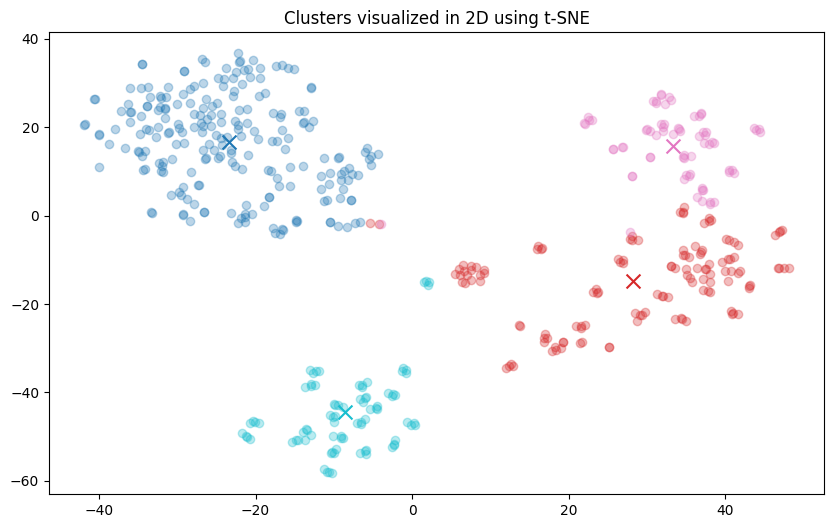

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Run t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

# Extract x and y coordinates
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

# Dynamically generate a colormap
n_clusters = df["Cluster"].nunique()
colors = cm.get_cmap("tab10", n_clusters)

plt.figure(figsize=(10, 6))

for category in range(n_clusters):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    
    plt.scatter(xs, ys, color=colors(category), alpha=0.3, label=f"Cluster {category}")
    
    # Compute and plot cluster centroid
    avg_x = xs.mean()
    avg_y = ys.mean()
    plt.scatter(avg_x, avg_y, marker="x", color=colors(category), s=100, edgecolor="black")

plt.title("Clusters visualized in 2D using t-SNE")


In [133]:
rev_per_cluster = 10

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    sampled_reviews = df[df.Cluster == i].Text.sample(rev_per_cluster, random_state=42).values
    # Make sure the reviews are not too long
    sampled_reviews = [review[:100000] for review in sampled_reviews]
    
    # Summarize each review individually
    summaries = []
    for review in sampled_reviews:
        summary_prompt = [
            {"role": "user", "content": f"Summarize the following text:\n\n\"\"\"\n{review}\n\"\"\""}
        ]
        
        summary_response = openai_client.chat.completions.create(
            model="gpt-4o",
            messages=summary_prompt,
            temperature=0,
            max_tokens=64,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0
        )
        
        summary = summary_response.choices[0].message.content.strip()
        summaries.append(summary)

    # Combine the summaries into a single text
    combined_summaries = "\n".join(summaries)

    # Ask what these summaries have in common
    theme_prompt = [
        {
            "role": "user",
            "content": f"What do the following summaries have in common?\n\nSummaries:\n\"\"\"\n{combined_summaries}\n\"\"\"\n\nTheme:"
        }
    ]

    theme_response = openai_client.chat.completions.create(
        model="gpt-4o",
        messages=theme_prompt,
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )

    print(theme_response.choices[0].message.content.replace("\n", ""))

    # Print the first few characters of each sampled review
    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)

Cluster 0 Theme: The common theme among these summaries is that they all describe various documentary or factual programs and narratives that explore different aspects of human society, history, and the natural world. Each summary provides an overview of a specific topic, ranging from crime investigations, historical events, and political figures, to wildlife, human-animal relationships, and
Subtitles for Ooggetuige II ( 16 ) Wie kent de inbrekers die in Warege
Subtitles for Het Derde Oog - Het gesticht Aan de rand van Gent , midd
Subtitles for Histories - Apocalyps toen ( 3 ) Goedenavond . Vanavond 
Subtitles for Kijk Uit ! - Veilighedisgordel zo Elk jaar voert het Ins
Subtitles for Panorama - De familie Saddam Saddam zit in een cel op zi
Subtitles for Rare Streken - Wild Indonesia ( 2 Dit is het verhaal van
Subtitles for Rare Streken - Triomf Van Het Le In de strijd om te over
Subtitles for Panorama - De keizer van Italiº Hij is tot eind dit jaar
Subtitles for Rare Streken - United S

In [60]:
class BiblicalChecker(str, Enum):
    is_biblical = "yes"
    is_not_biblical = "no"

class Biblical(BaseModel):
    type: BiblicalChecker

class AsyncBiblicalChecker:
    def __init__(self, df: pd.DataFrame, text_column: str, async_openai_client, max_concurrent_requests=20):
        self.df = df
        self.text_column = text_column
        self.client = async_openai_client
        self.semaphore = asyncio.Semaphore(max_concurrent_requests)

    async def check_biblical(self, text: str) -> str:
        """Asynchronously checks if a given text is biblical."""
        try:
            truncated_text = " ".join(text.split()[:1000])

            async with self.semaphore:  # Ensure limit of concurrent requests
                response = await async_openai_client.beta.chat.completions.parse(
                model="gpt-4o-2024-08-06",
                messages=[
                    {"role": "system", "content": "Determine if the provided text is biblical. Respond with 'Yes' or 'No'."},
                    {"role": "user", "content": f"Is the following text biblical? {truncated_text}"},
                ],
                response_format=Biblical,
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            return f"Error: {str(e)}"

    async def process_dataframe(self):
        """Processes the DataFrame asynchronously."""
        tasks = [self.check_biblical(row[self.text_column]) for _, row in self.df.iterrows()]
        results = await asyncio.gather(*tasks)
        self.df["is_biblical"] = results
        return results

In [78]:
checker = AsyncBiblicalChecker(df, text_column="Text", async_openai_client=async_openai_client)

async def run_checker():
    results = await checker.process_dataframe()
    return results

results = await run_checker()

In [136]:
pd.set_option('display.max_colwidth', None)

# Get the percentage of biblical texts (i.e. if is_biblical contains "yes") in the DataFrame, which would be {"type": "yes"}
biblical_percentage = (checker.df["is_biblical"] == '{"type":"yes"}').mean()
print(f"Biblical text percentage: {biblical_percentage:.2%}")

# Print only the biblical texts
biblical_texts = checker.df[checker.df["is_biblical"] == '{"type":"no"}']
print(biblical_texts["Text"].sample(5).values)

# Save the DataFrame to a CSV file
checker.df.to_csv("biblical_check.csv", index=False)

Biblical text percentage: 49.61%
["Manuel Vázquez Montalban Autobiografie van generaal Franco Vertaald door Saskia Otter Maar we hebben zojuist gezien dat de ruis ook vertaald wordt in een bepaalde vorm , in een bepaald spectrum , waarin enkele componenten vaker voorkomen dan anderen . Hij is verbonden met de graad van relatieve ongeordendheid van het universum ( entropie ) , in verhouding tot de graad van de door het signaal opgelegde orde ( negatieve entropie ) , zoals de werken van Szilard en van Brioullin hebben bewezen . Einstein heeft aangetoond dat de globale energie voortgebracht door de ruis groter was als het kanaal hem meer mogelijkheden gaf om zich te manifesteren ; naarmate de bandbreedte , dat wil zeggen het geheel van aleatorische vormen die konden worden doorgegeven , groter was . Bovendien heeft hij bewezen dat als deze ruis buiten de toevallige of opzettelijke signalen viel , dat wil zeggen de toevallige superpositie was van twee boodschappen bestemd voor twee onderli

In [137]:
# Print the different values in the is_biblical column
print(checker.df["is_biblical"].value_counts())

is_biblical
{"type":"no"}     256
{"type":"yes"}    252
Name: count, dtype: int64


In [139]:
# read in the CSV file
pd.options.display.max_colwidth = 250
biblical_check = pd.read_csv("../out/biblical_check.csv")

biblical_check.sample(5)

Title  \
109  WR-P-P-B-0000000116.dcoi   
363  WR-P-P-B-0000000372.dcoi   
8    WR-P-P-B-0000000011.dcoi   
365  WR-P-P-B-0000000374.dcoi   
333  WR-P-P-B-0000000341.dcoi   

                                                                                                                                                                                                                                                          Text  \
109  Het komt wel goed , juf ! Voor Nille Inhoud Proloog Het vmbo / mbo in vogelvlucht Een leven voor de klas 1 Ontslag 2 Voor de leeuwen 3 Het klappen van de zweep 4 Een vaste aanstelling 5 Afsluiting van het eerste semester 6 Het tweede semester 7 R...   
363  De invloed van de fysieke omgeving op lichamelijke activiteit : Beleid voor beweegvriendelijke wijken Inhoudsopgave ( removed ) INLEIDING Vrijwel iedereen hecht veel waarde aan een lang en gezond leven . Echter , door onder andere overgewicht ond...   
8    Aarde . Onze Levende Bibliotheek : Aarde Lessen van de Pleiadiërs BARBARA MARCINIAK in samenwerking met KAREN MARCINIAK TERA THOMAS Uitgeverij Petiet / Laren Oorspronkelijke titel : EARTH [ Pleiadian Keys to the Living Library ] by Barbara Marcin...   
365  Obadja Obadja 1 1 Hier volgt wat God , de Heer , in een visioen aan Obadja bekendmaakte over het lot van Edom . 1 De Heer zal Edom straffen 1 Een bode is gestuurd naar de volken , 1 hij komt van de Heer ; 1 wij hebben zijn boodschap gehoord : 1 '...   
333  Inleiding op de eerste brief aan Timoteüs Inleiding op de eerste brief aan Timoteüs DE TWEE BRIEVEN aan Timoteüs ( 1 en 2 Tim ) en de brief aan Titus ( Tit ) worden al vanouds als een aparte groep beschouwd . Sinds de achttiende eeuw worden ze de...   

        is_biblical  
109   {"type":"no"}  
363   {"type":"no"}  
8     {"type":"no"}  
365  {"type":"yes"}  
333   {"type":"no"}

In [108]:
# Azure storage account credentials
source_container_name = "books"
destination_container_name = "booksbiblical"

# Load dataframe
df = pd.read_csv("biblical_check.csv")

# Extract non-biblical filenames
non_biblical_files = df[df['is_biblical'].str.contains('yes', case=False)]['Title'].tolist()

# Put '.xml' extension back to the filenames
non_biblical_files = [f"{filename}.xml" for filename in non_biblical_files]
print(f"Number of non-biblical files: {len(non_biblical_files)}")
print(non_biblical_files)

# Initialize Blob Service Client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
source_container_client = blob_service_client.get_container_client(source_container_name)
destination_container_client = blob_service_client.get_container_client(destination_container_name)

# Iterate over blobs in source container and copy non-biblical files
for blob in source_container_client.list_blobs():
    filename = blob.name
    
    if filename in non_biblical_files:
        source_blob_client = source_container_client.get_blob_client(blob.name)
        destination_blob_client = destination_container_client.get_blob_client(blob.name)
        
        # Copy blob
        destination_blob_client.start_copy_from_url(source_blob_client.url)
        print(f"Copied {blob.name} to {destination_container_name}")

print("Copy process completed.")

Number of non-biblical files: 252
['WR-P-P-B-0000000071.dcoi.xml', 'WR-P-P-B-0000000072.dcoi.xml', 'WR-P-P-B-0000000073.dcoi.xml', 'WR-P-P-B-0000000074.dcoi.xml', 'WR-P-P-B-0000000075.dcoi.xml', 'WR-P-P-B-0000000076.dcoi.xml', 'WR-P-P-B-0000000077.dcoi.xml', 'WR-P-P-B-0000000078.dcoi.xml', 'WR-P-P-B-0000000079.dcoi.xml', 'WR-P-P-B-0000000080.dcoi.xml', 'WR-P-P-B-0000000081.dcoi.xml', 'WR-P-P-B-0000000082.dcoi.xml', 'WR-P-P-B-0000000083.dcoi.xml', 'WR-P-P-B-0000000084.dcoi.xml', 'WR-P-P-B-0000000085.dcoi.xml', 'WR-P-P-B-0000000086.dcoi.xml', 'WR-P-P-B-0000000087.dcoi.xml', 'WR-P-P-B-0000000088.dcoi.xml', 'WR-P-P-B-0000000089.dcoi.xml', 'WR-P-P-B-0000000090.dcoi.xml', 'WR-P-P-B-0000000091.dcoi.xml', 'WR-P-P-B-0000000092.dcoi.xml', 'WR-P-P-B-0000000093.dcoi.xml', 'WR-P-P-B-0000000094.dcoi.xml', 'WR-P-P-B-0000000095.dcoi.xml', 'WR-P-P-B-0000000096.dcoi.xml', 'WR-P-P-B-0000000097.dcoi.xml', 'WR-P-P-B-0000000098.dcoi.xml', 'WR-P-P-B-0000000099.dcoi.xml', 'WR-P-P-B-0000000245.dcoi.xml', 'WR-P

In [62]:
class PlotMaker:
    def __init__(self, corpus_part=None):
        self.corpus_part = corpus_part
        self.df = None
    
    def load_data(self, file_path):
        """Loads the word frequency data from a CSV file."""
        if self.corpus_part is None:
            raise ValueError("No corpus_part provided.")
        
        self.df = pd.read_csv(file_path)
    
    def word_frequency_distribution(self, top_n=20, remove_stopwords=True):
        """Plots a word frequency distribution."""
        # Load the DataFrame
        file_path = f"../out/{self.corpus_part}/word_frequencies_{self.corpus_part}.csv"
        self.load_data(file_path)

        if remove_stopwords:
            # Load Dutch stopwords
            stopwords = set(nltk.corpus.stopwords.words("dutch"))
            
            print(f"Removing {len(stopwords)} stopwords...")
            print(f"Example stopwords: {list(stopwords)[:5]}")
            print(f"Original DataFrame shape: {self.df.shape}")

            # Remove stopwords, punctuation, and non-alphabetic words
            self.df = self.df[
                ~self.df["Word"].str.lower().isin(stopwords) &   # Stopwords removal
                self.df["Word"].str.isalpha() &                  # Remove non-alphabetic words
                ~self.df["Word"].isin(set(string.punctuation))   # Remove punctuation
            ]

            print(f"New DataFrame shape: {self.df.shape}")
        top_words = self.df.nlargest(top_n, 'Frequency')
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=top_words, x='Word', y='Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Word")
        plt.ylabel("Frequency")
        plt.title(f"Top {top_n} Words by Frequency")
        plt.show()

    def word_count_distribution(self, bins=20):
        """Plots a word count distribution."""
        # Load the DataFrame
        file_path = f"../out/{self.corpus_part}/wordcount_and_10gram_perfile_{self.corpus_part}.csv"
        self.load_data(file_path)
        
        plt.figure(figsize=(12, 6))
        sns.histplot(self.df["word_count"], bins=bins, kde=True, edgecolor="black", alpha=0.7)
        plt.xlabel("Word Count")
        plt.ylabel("Frequency")
        plt.title("Distribution of Word Count per File")
        plt.show()

    def filename_vs_wordcount(self, top_n=10, ascending=False):
        """Plots the top N filenames by word count."""
        # Load the DataFrame
        file_path = f"../out/{self.corpus_part}/wordcount_and_10gram_perfile_{self.corpus_part}.csv"
        self.load_data(file_path)

        df_sorted = self.df.sort_values(by="word_count", ascending=ascending).head(20)
        plt.figure(figsize=(10, 5))
        
        bars = plt.barh(df_sorted["filename"], df_sorted["word_count"], color="skyblue")
        plt.xlabel("Word Count")
        plt.ylabel("Filename")
        if ascending:
            plt.title("Bottom 20 Files by Word Count")
        else:
            plt.title("Top 20 Files by Word Count")
        plt.gca().invert_yaxis()

        # Add word count labels to the bars
        for bar, word_count in zip(bars, df_sorted["word_count"]):
            plt.text(word_count, bar.get_y() + bar.get_height()/2, f"{word_count:,}", va='center', ha='left', fontsize=10)

        plt.show()


Removing 101 stopwords...
Example stopwords: ['wat', 'altijd', 'ge', 'en', 'nu']
Original DataFrame shape: (342999, 2)
New DataFrame shape: (296779, 2)


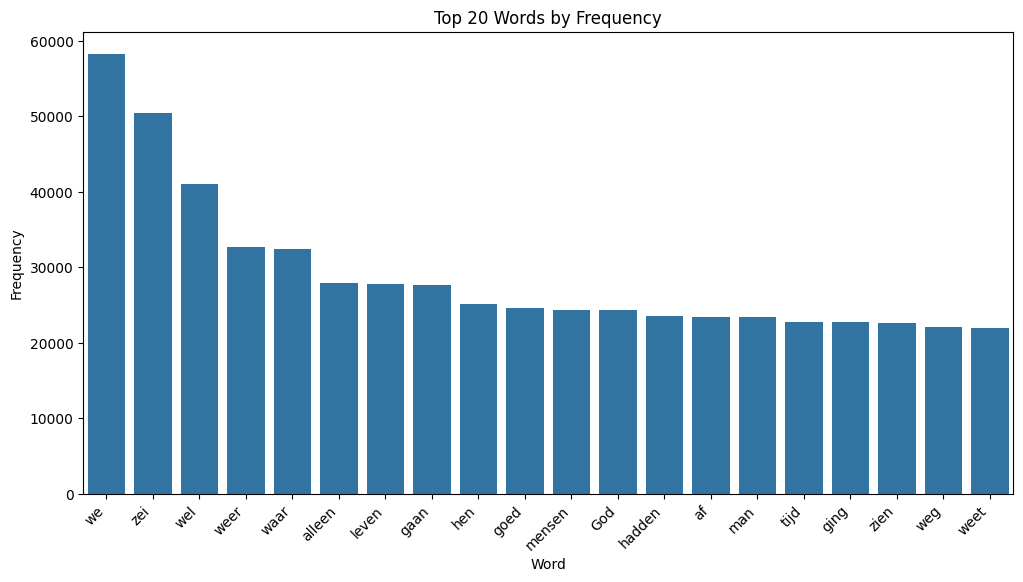

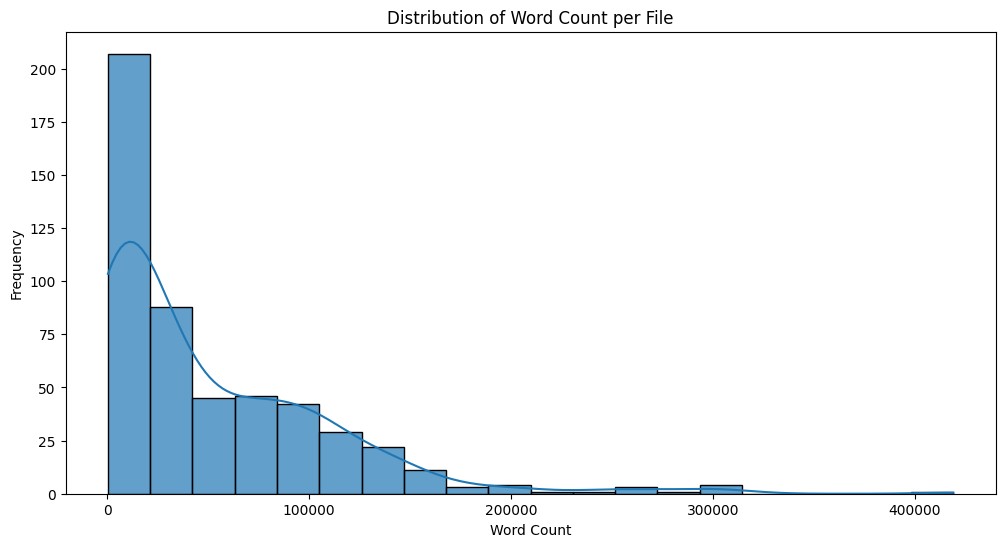

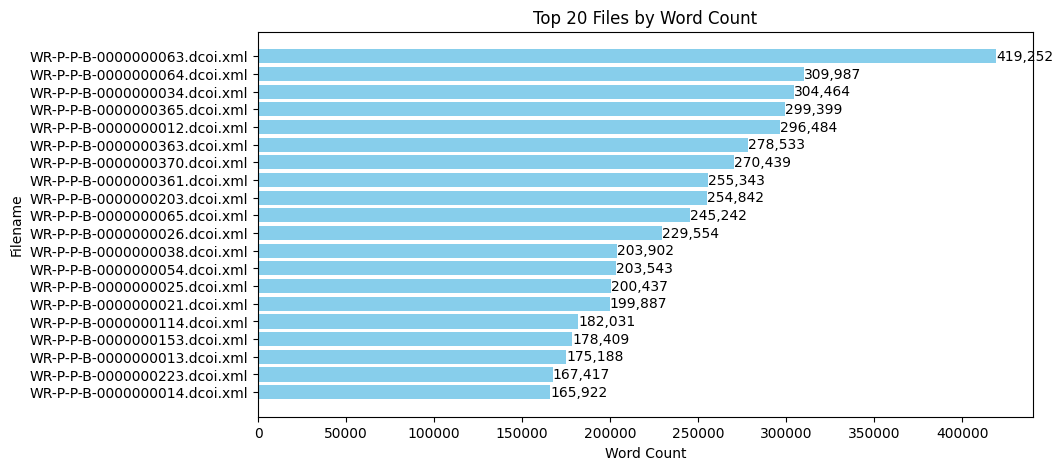

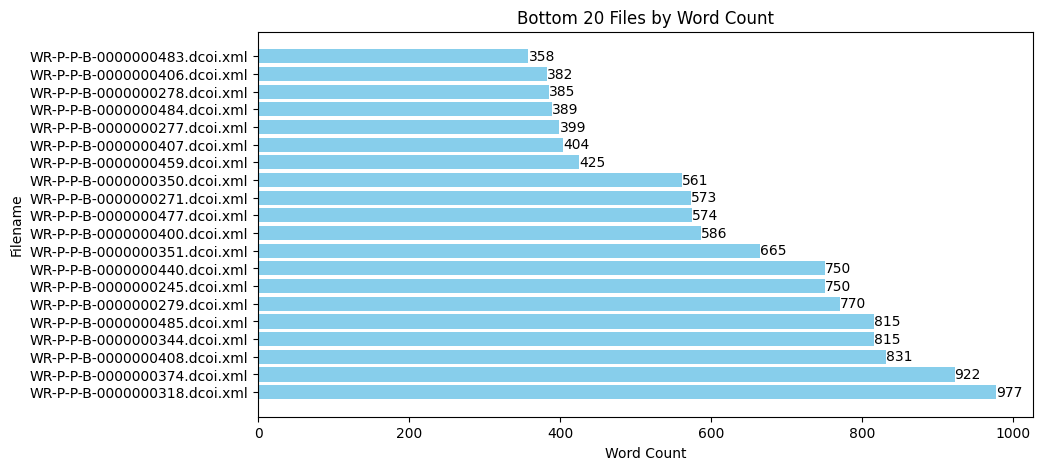

In [130]:
plot_maker = PlotMaker("books")

plot_maker.word_frequency_distribution(top_n=20, remove_stopwords=True)
plot_maker.word_count_distribution(bins=20)
plot_maker.filename_vs_wordcount(top_n=10)
plot_maker.filename_vs_wordcount(top_n=10, ascending=True)

In [84]:
gendered_wordpairs_list = [
    'man', 'vrouw',
    'Man', 'Vrouw',
    'mannen', 'vrouwen',
    'Mannen', 'Vrouwen',
    'jongen', 'meisje',
    'Jongen', 'Meisje',
    'jongens', 'meisjes',
    'Jongens', 'Meisjes',
    'jongetje', 'meisje',
    'Jongetje', 'Meisje',
    'jongetjes', 'meisjes',
    'Jongetjes', 'Meisjes',
    'kerel', 'meid',
    'Kerel', 'Meid',
    'kerels', 'meiden',
    'Kerels', 'Meiden',
    'gozer', 'meid',
    'Gozer', 'Meid',
    'gozers', 'meiden',
    'Gozers', 'Meiden',
    'gozer', 'wijf',
    'Gozer', 'Wijf',
    'gozers', 'wijven',
    'Gozers', 'Wijven',
    'gentleman', 'lady',
    'Gentleman', 'Lady',
    'lord', 'lady',
    'Lord', 'Lady',
    'heer', 'dame',
    'Heer', 'Dame',
    'heren', 'dames',
    'Heren', 'Dames',
    'meneer', 'mevrouw',
    'Meneer', 'Mevrouw',
    'mijnheer', 'mevrouw',
    'Mijnheer', 'Mevrouw',
    'mister', 'miss',
    'Mister', 'Miss',
    'Mr.', 'Ms.',
    'Mr', 'Ms',
    'Mr.', 'Mrs.',
    'Mr', 'Mrs',
    'mannelijk', 'vrouwelijk',
    'Mannelijk', 'Vrouwelijk',
    'mannelijke', 'vrouwelijke',
    'Mannelijke', 'Vrouwelijke',
    'koning', 'koningin',
    'Koning', 'Koningin',
    'koningen', 'koninginnen',
    'Koningen', 'Koninginnen',
    'prins', 'prinses',
    'Prins', 'Prinses',
    'prinsen', 'prinsessen',
    'Prinsen', 'Prinsessen',
    'hertog', 'hertogin',
    'Hertog', 'Hertogin',
    'hertogen', 'hertoginnen',
    'monnik', 'non',
    'Monnik', 'Non',
    'monniken', 'nonnen',
    'Monniken', 'Nonnen',
    'baron', 'barones',
    'Baron', 'Barones',
    'hij', 'zij',
    'Hij', 'Zij',
    'hijzelf', 'zijzelf',
    'Hijzelf', 'Zijzelf',
    'vader', 'moeder',
    'Vader', 'Moeder',
    'vaders', 'moeders',
    'Vaders', 'Moeders',
    'papa', 'mama',
    'Papa', 'Mama',
    'papa\'s', 'mama\'s',
    'Papa\'s', 'Mama\'s',
    'pappa', 'mamma',
    'Pappa', 'Mamma',
    'pappa\'s', 'mamma\'s',
    'Pappa\'s', 'Mamma\'s',
    'broer', 'zus',
    'Broer', 'Zus',
    'broers', 'zussen',
    'Broers', 'Zussen',
    'neef', 'nicht',
    'Neef', 'Nicht',
    'neven', 'nichten',
    'oom', 'tante',
    'Oom', 'Tante',
    'ooms', 'tantes',
    'grootvader', 'grootmoeder',
    'Grootvader', 'Grootmoeder',
    'grootvaders', 'grootmoeders',
    'Grootvaders', 'Grootmoeders',
    'opa', 'oma',
    'Opa', 'Oma',
    'opa\'s', 'oma\'s',
    'Opa\'s', 'Oma\'s',
    'zoon', 'dochter',
    'Zoon', 'Dochter',
    'zonen', 'dochters',
    'Zonen', 'Dochters',
    'kleinzoon', 'kleindochter',
    'Kleinzoon', 'Kleindochter',
    'kleinzonen', 'kleindochters',
    'schoonzoon', 'schoondochter',
    'Schoonzoon', 'Schoondochter',
    'schoonzonen', 'schoondochters',
    'stiefvader', 'stiefmoeder',
    'Stiefvader', 'Stiefmoeder',
    'stiefvaders', 'stiefmoeders',
    'Stiefvaders', 'Stiefmoeders',
    'stiefzoon', 'stiefdochter',
    'Stiefzoon', 'Stiefdochter',
    'stiefzonen', 'stiefdochters',
    'schoonvader', 'schoonmoeder',
    'schoonvaders', 'schoonmoeders',
    'bruidegom', 'bruid',
    'Bruidegom', 'Bruid',
    'bruidegoms', 'bruiden',
    'peetvader', 'peetmoeder',
    'Peetvader', 'Peetmoeder',
]



In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class GenderedWordsPlotter:
    def __init__(self, corpus_part=None, gendered_wordpairs_list=None):
        """
        Initializes the plotter.
        
        Parameters:
            corpus_part (str): A subsection of the corpus (e.g., "books").
            gendered_wordpairs_list (list): A list of words where every two consecutive items
                                            form a male/female pair.
        """
        if corpus_part is None:
            raise ValueError("You must provide a corpus_part (e.g., 'books').")
        if gendered_wordpairs_list is None:
            raise ValueError("You must provide a gendered_wordpairs_list.")
            
        self.corpus_part = corpus_part
        self.df = None
        
        self.gendered_wordpairs_list = gendered_wordpairs_list
        # Create pairs
        self.pairs = list(zip(gendered_wordpairs_list[0::2], gendered_wordpairs_list[1::2]))
        # Create lists for later use
        self.male_words = set(gendered_wordpairs_list[0::2])
        self.female_words = set(gendered_wordpairs_list[1::2])
    
    def load_data(self, file_path=None):
        """
        Loads the word frequency data from a CSV file.
        If no file_path is provided, builds one using the corpus_part.
        """
        if self.corpus_part is None:
            raise ValueError("No corpus_part provided.")
        
        if file_path is None:
            file_path = f"../out/{self.corpus_part}/gendered_wordpairs_{self.corpus_part}.csv"
        
        self.df = pd.read_csv(file_path)
        print(f"Data loaded from {file_path} with shape {self.df.shape}")
    
    def plot_gendered_word_pairs(self, n_largest=3):
        """
        Creates a grouped horizontal bar chart that shows the frequencies of each gendered word pair.
        The male and female frequencies for each pair (if present) are plotted side-by-side.
        Also identifies and highlights the top 3 pairs with the biggest frequency differences.
        """
        # Load data if not already loaded.
        if self.df is None:
            self.load_data()

        pair_freq = []
        for male, female in self.pairs:
            # Sum frequencies for exact word matches.
            male_freq = self.df.loc[self.df['Word'] == male, 'Frequency'].sum()
            female_freq = self.df.loc[self.df['Word'] == female, 'Frequency'].sum()

            # Only include pairs with any frequency.
            if male_freq + female_freq > 0:
                pair_freq.append({
                    'pair': f"{male}/{female}",
                    'Male': male_freq,
                    'Female': female_freq,
                    'Difference': abs(male_freq - female_freq)  # Compute the absolute difference.
                })

        pair_df = pd.DataFrame(pair_freq)
        if pair_df.empty:
            print("No matching gendered word pairs found in the DataFrame.")
            return

        # Identify the top 3 pairs with the largest differences.
        top_pairs = pair_df.nlargest(n_largest, 'Difference')
        print("Top 3 pairs with the biggest difference:")
        print(top_pairs[['pair', 'Difference']])

        ind = np.arange(len(pair_df))
        height = 0.35  # Width of the bars.

        fig, ax = plt.subplots(figsize=(10, 15))
        bars_male = ax.barh(ind - height/2, pair_df['Male'], height, label='Male', color='lightskyblue')
        bars_female = ax.barh(ind + height/2, pair_df['Female'], height, label='Female', color='lightpink')

        # Highlight the top 3 pairs by drawing an outline around their bars.
        for i, row in pair_df.iterrows():
            if row['pair'] in top_pairs['pair'].values:
                # Add a black edge to the male bar.
                ax.barh(i - height/2, row['Male'], height,
                        edgecolor='black', linewidth=1, fill=False)
                # Add a black edge to the female bar.
                ax.barh(i + height/2, row['Female'], height,
                        edgecolor='black', linewidth=1, fill=False)

        ax.set_xlabel('Frequency')
        ax.set_xscale('log')
        fig.suptitle('Frequency of Gendered Words by Pair', x=0.6)
        ax.set_title(f"The black outlined bars represent the top {n_largest} pairs with the biggest frequency differences.", fontsize=10)
        ax.set_yticks(ind)
        ax.set_yticklabels(pair_df['pair'])
        ax.legend()

        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Create a separate plot for the top 3 differences.
        fig2, ax2 = plt.subplots(figsize=(8, 4))

        # Set the color for each bar: lightskyblue if Male frequency is higher (or equal), lightpink if Female is higher.
        colors = ['lightskyblue' if row['Male'] >= row['Female'] else 'lightpink' 
                for _, row in top_pairs.iterrows()]

        ax2.barh(top_pairs['pair'], top_pairs['Difference'], color=colors)
        ax2.set_xlabel('Absolute Frequency Difference')
        ax2.set_title('Top 3 Word Pairs with the Biggest Frequency Difference')
        ax2.invert_yaxis()  # Highest difference at the top.
        plt.tight_layout()
        plt.show()

    def plot_gender_distribution(self, n_largest=3):
        """
        Plots two pie charts as subplots:
        - Left: the overall frequency distribution of gendered words.
        - Right: the frequency distribution after excluding the top n difference pairs.
        
        Parameters:
            n_largest (int): Number of top-difference pairs to exclude in the second pie chart.
        """
        # Ensure data is loaded.
        if self.df is None:
            self.load_data()

        male_total_all = self.df[self.df['Word'].isin(self.male_words)]['Frequency'].sum()
        female_total_all = self.df[self.df['Word'].isin(self.female_words)]['Frequency'].sum()

        pair_freq = []
        for male, female in self.pairs:
            # Sum frequencies for the exact word matches.
            male_freq = self.df.loc[self.df['Word'] == male, 'Frequency'].sum()
            female_freq = self.df.loc[self.df['Word'] == female, 'Frequency'].sum()
            if male_freq + female_freq > 0:
                pair_freq.append({
                    'pair': f"{male}/{female}",
                    'Male': male_freq,
                    'Female': female_freq,
                    'Difference': abs(male_freq - female_freq)
                })
        
        pair_df = pd.DataFrame(pair_freq)
        if pair_df.empty:
            print("No matching gendered word pairs found in the DataFrame.")
            return

        # Identify the top n pairs with the largest absolute frequency differences.
        top_pairs = pair_df.nlargest(n_largest, 'Difference')

        # Collect the words (both male and female) from these top pairs.
        top_words = set()
        for pair in top_pairs['pair']:
            m, f = pair.split('/')
            top_words.update([m, f])

        # For male, remove any word that is in top_words.
        male_total_excl = self.df[self.df['Word'].isin(self.male_words - top_words)]['Frequency'].sum()
        # Likewise for female.
        female_total_excl = self.df[self.df['Word'].isin(self.female_words - top_words)]['Frequency'].sum()

        fig, axs = plt.subplots(1, 2, figsize=(16, 8))

        # Pie chart for the overall distribution.
        totals_all = [male_total_all, female_total_all]
        axs[0].pie(totals_all,
                labels=['Male', 'Female'],
                autopct='%1.1f%%',
                colors=['lightskyblue', 'lightpink'],
                startangle=90)
        axs[0].set_title("Total Frequency of Gendered Words (All Pairs)")
        axs[0].axis('equal')  # Ensures the pie is drawn as a circle.

        # Pie chart for the distribution excluding top difference pairs.
        totals_excl = [male_total_excl, female_total_excl]
        axs[1].pie(totals_excl,
                labels=['Male', 'Female'],
                autopct='%1.1f%%',
                colors=['lightskyblue', 'lightpink'],
                startangle=90)
        axs[1].set_title(f"Frequency Excluding Top {n_largest} Difference Pairs")
        axs[1].axis('equal')

        plt.tight_layout()
        plt.show()


Data loaded from ../out/books/gendered_wordpairs_books.csv with shape (122, 3)
Top 3 pairs with the biggest difference:
               pair  Difference
30          hij/zij      223201
14        heer/dame       12327
21  koning/koningin       11972
48     zoon/dochter        6902


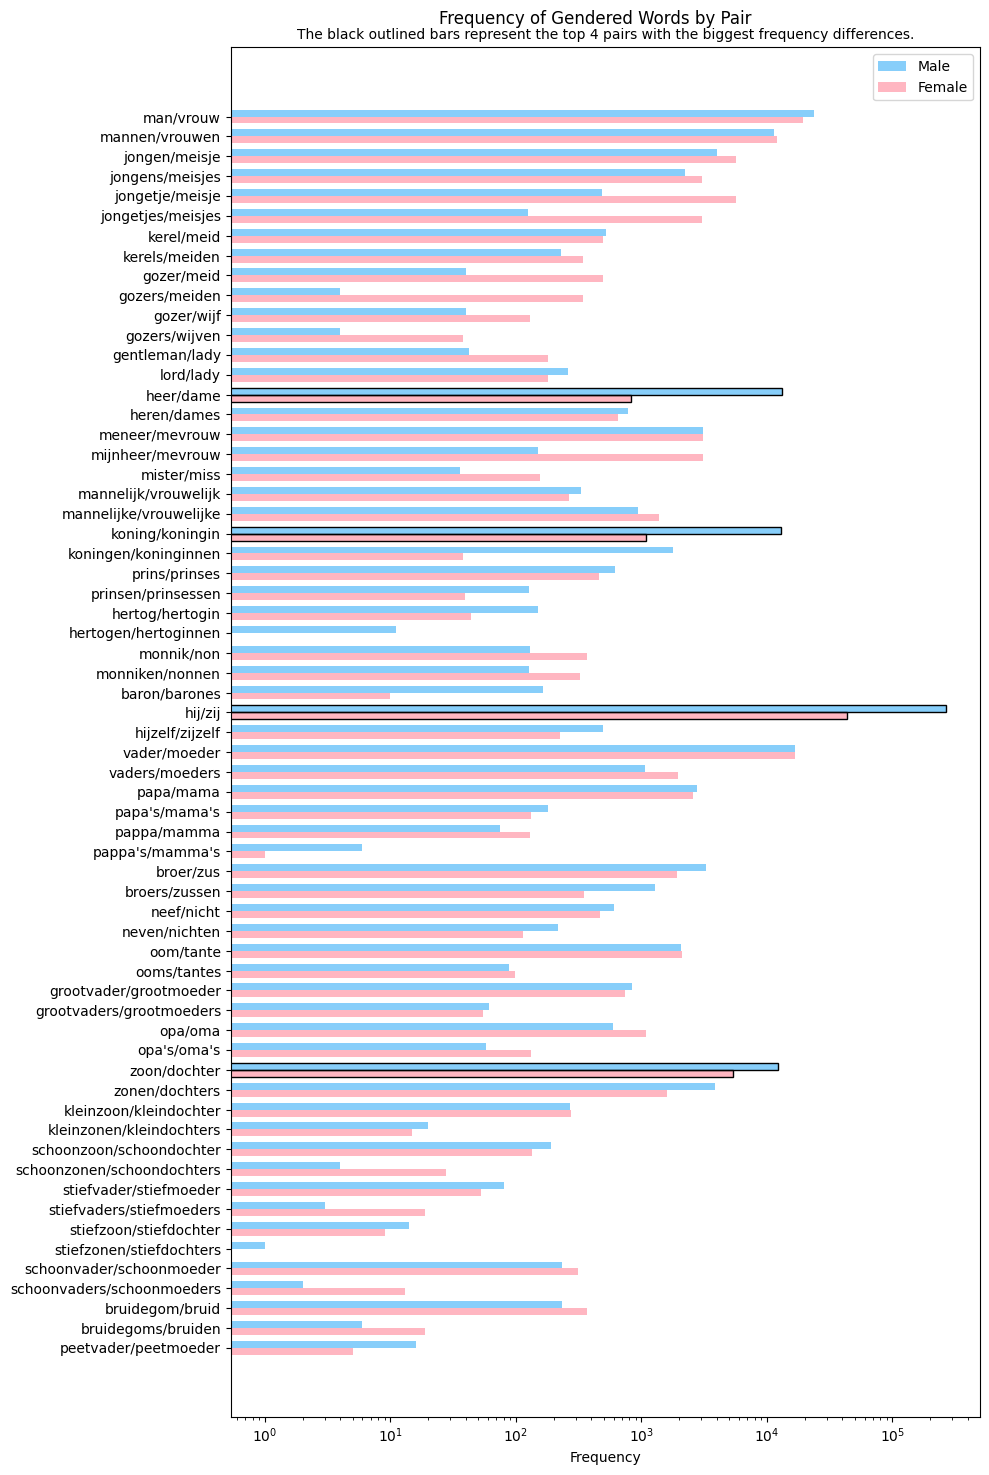

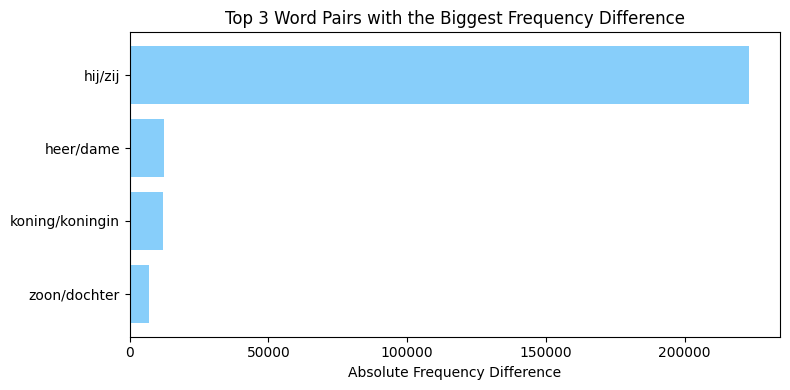

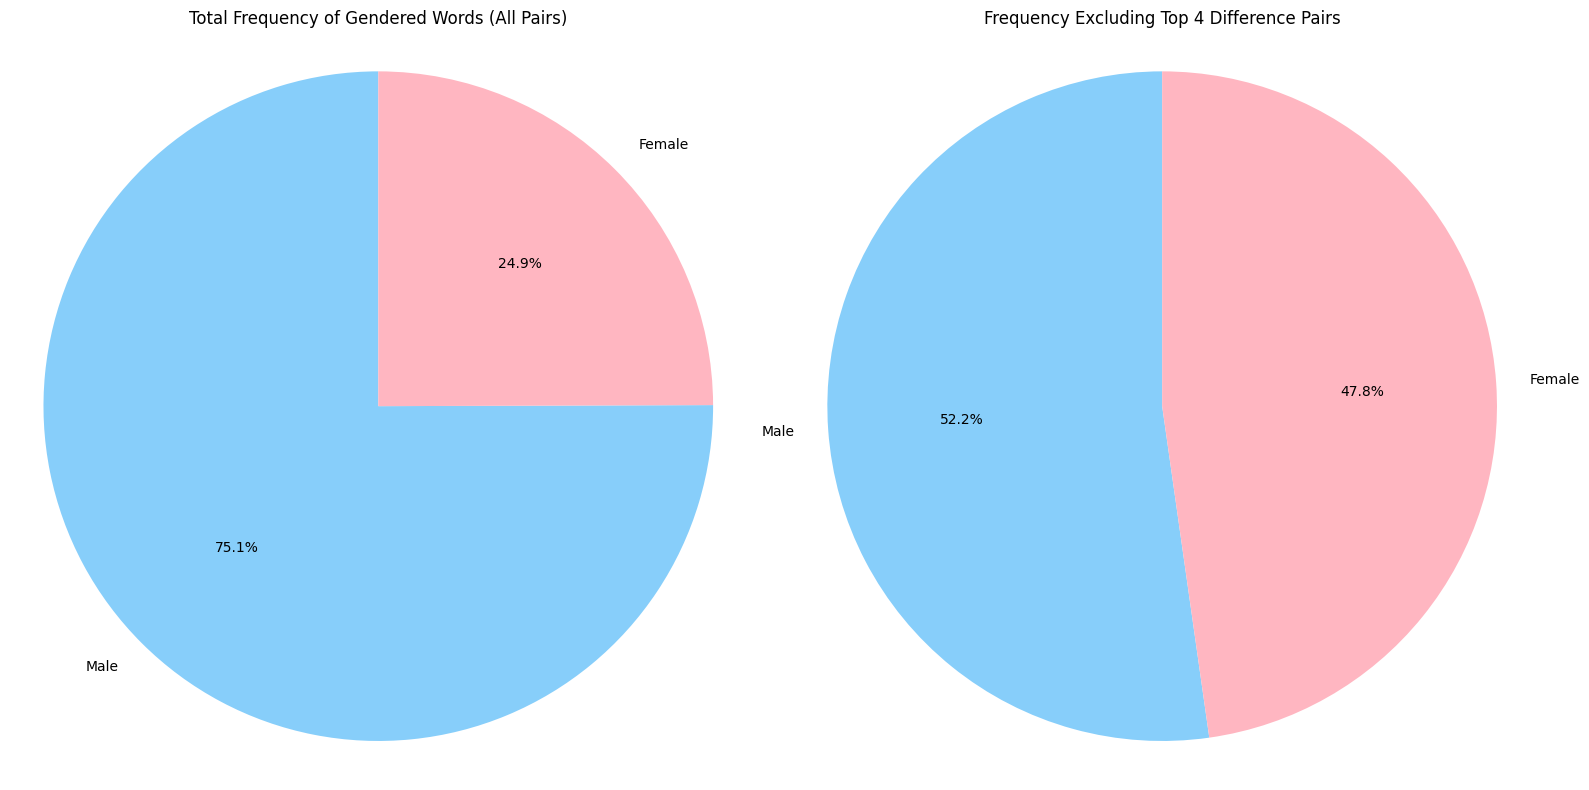

In [133]:
plotter = GenderedWordsPlotter(corpus_part="books", gendered_wordpairs_list=gendered_wordpairs_list)

plotter.plot_gendered_word_pairs(n_largest=4)
plotter.plot_gender_distribution(n_largest=4)


In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class ProfessionsPlotter:
    def __init__(self, corpus_part=None):
        """
        Initializes the plotter.
        
        Parameters:
            corpus_part (str): A subsection of the corpus (e.g., "books").
        """
        if corpus_part is None:
            raise ValueError("You must provide a corpus_part (e.g., 'books').")
        
        self.corpus_part = corpus_part
        self.df = None
    
    def load_data(self, file_path=None):
        """
        Loads the profession frequency data from a CSV file.
        If no file_path is provided, builds one using the corpus_part.
        """
        if self.corpus_part is None:
            raise ValueError("No corpus_part provided.")
        
        if file_path is None:
            file_path = f"../out/{self.corpus_part}/professions_{self.corpus_part}.csv"
        
        self.df = pd.read_csv(file_path)
        self.df = self.df.sort_values(by='Frequency', ascending=False)
        print(f"Data loaded from {file_path} with shape {self.df.shape}")
    
    def plot_top_n_professions(self, n=10):
        """Plots a bar chart of the top N professions by frequency."""
        if self.df is None:
            self.load_data()
        
        top_n_df = self.df.head(n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(top_n_df['Word'], top_n_df['Frequency'], color='royalblue')
        plt.xlabel("Frequency")
        plt.ylabel("Profession")
        plt.title(f"Top {n} Most Frequent Professions")
        plt.gca().invert_yaxis()  # Highest frequency at the top
        plt.show()

Data loaded from ../out/subtitles/professions_subtitles.csv with shape (74, 2)


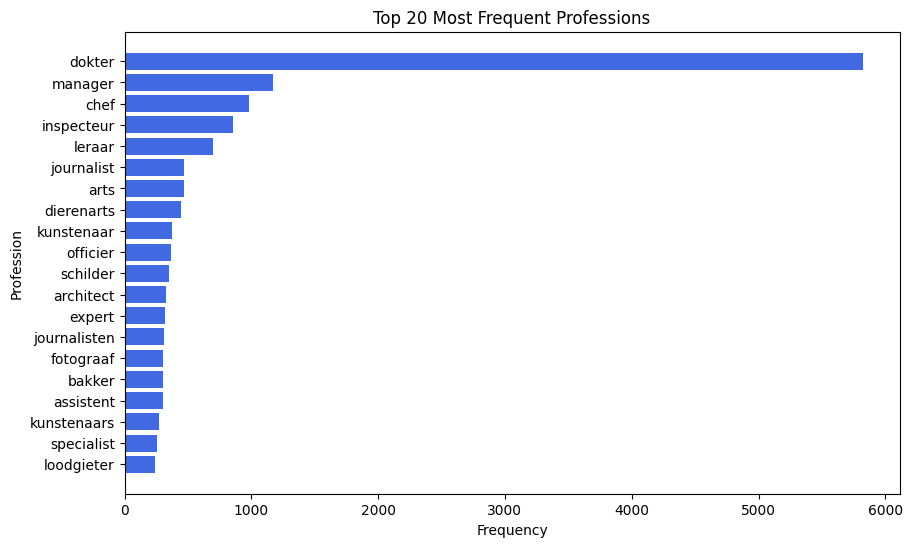

In [132]:
profession_plotter = ProfessionsPlotter(corpus_part="subtitles")
profession_plotter.plot_top_n_professions(n=20)